# Tree Based Methods

Tree based methods are a powerful set of tools we may use to construct predictive models. Trees are used to segment the feature space into regions. Unlike linear regression or logistic regression, where we had a single hyperplane and a single equation to predict our results, trees provide a set of binary splits. Interpreting and making predictions with trees is simple and easily understandable but single trees have their limitations. To improve upon the predictive power of single trees, we introduce bagging (Bootstrap Aggregating), random forests, and boosting. While the predictive power random forest is considerably more than a single tree, we lose interpretation and prediction becomes challenging.

## Carseats Dataset
we will be using the **carseats** dataset, which has data on 400 different stores:


| Feature Name |                    Description                   |
|:------------:|:------------------------------------------------:|
|     Sales    |              Unit sales in thousands             |
|  Comp Price  |                 Competitor price                 |
|    Income    |              Community income level              |
|  Advertising | Local advertising budget in thousands of dollars |
|  Population  |            population size (thousands)           |
|     Price    |         Price company charges per carseat        |
|   ShelveLoc  |        Good, Medium,Bad shelving location        |
|      Age     |          Average age of local population         |
|   Education  |       Average education of local population      |
|     Urban    |   Categorical indicating if the store is urban   |
|      US      | Categorical indicating if the store is in the US |

## Getting Started

We will need to install a few more packages to visualize the decision trees.

**If you are running Anaconda, type in the Anaconda terminal**:

*conda install python-graphviz*

*conda install graphviz*

*conda install -c anaconda pydotplus*

If you are using a Mac, that's it.

If on Windows, add the following to Environment Variables -> Path, replacing {username}:

*C:\Users\ {username}\Anaconda3\Library\bin\graphviz*

**If you are running Google Collab, you don't need to do anything**

Afterwards, make sure to restart the kernel!!!

In [2]:
#Data Wrangling
import numpy as np
import pandas as pd

#Trees
from sklearn import tree
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Preprocessing Packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer #One hot encoding
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus

#Bootstrap
from sklearn.utils import resample

%matplotlib inline

### Fitting Classification Trees

#### Visualizing Segmentation
First, we start by constructing small trees. The great thing about decision trees is that they are easy to interpret, unlike some models we may encounter later. Let's consider 2 features, **price** and **competitor**, to visualize how the feature space is segmented to predict **sales**. We see that sales is a continuous variable. While we can perform random forest to predict continuous variables, today we focuse on predicting categorical variables. Hence, lets convert this to a categorical "High", "Low" level of sales with a threshold of 8.

In [3]:
#Import data and take a look at features
data = pd.read_csv('carseats.csv')
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [4]:
data['Sales'].describe()

,Sales
count,400.000000
mean,7.496325
std,2.824115
min,0.000000
25%,5.390000
50%,7.490000
75%,9.320000
max,16.270000


In [5]:
#Convert sales to a binary variable
data['High'] = ["Yes" if sales>8 else "No" for sales in data['Sales']]
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,No
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,No


In [6]:
# Define a function to select features before preprocessing.
# Every function passed into pipeline must contain a constructor, fit and transform method
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y = None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

#Once the OneHot encoding is performed, return a subset of the matrix
# We have three levels for ShelveLoc Bad,Good,Medium. In reality we need only 2 levels to express all the information
#Hence, this selects a subset.
class CatagorySubset(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[:,1:]

Since sklearn's LabelBinarizer only takes in two arguments, we also need to override the method.

In [7]:
# Override to use three arguments
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

Training Accuracy =  0.73
Training Accuracy =  0.73


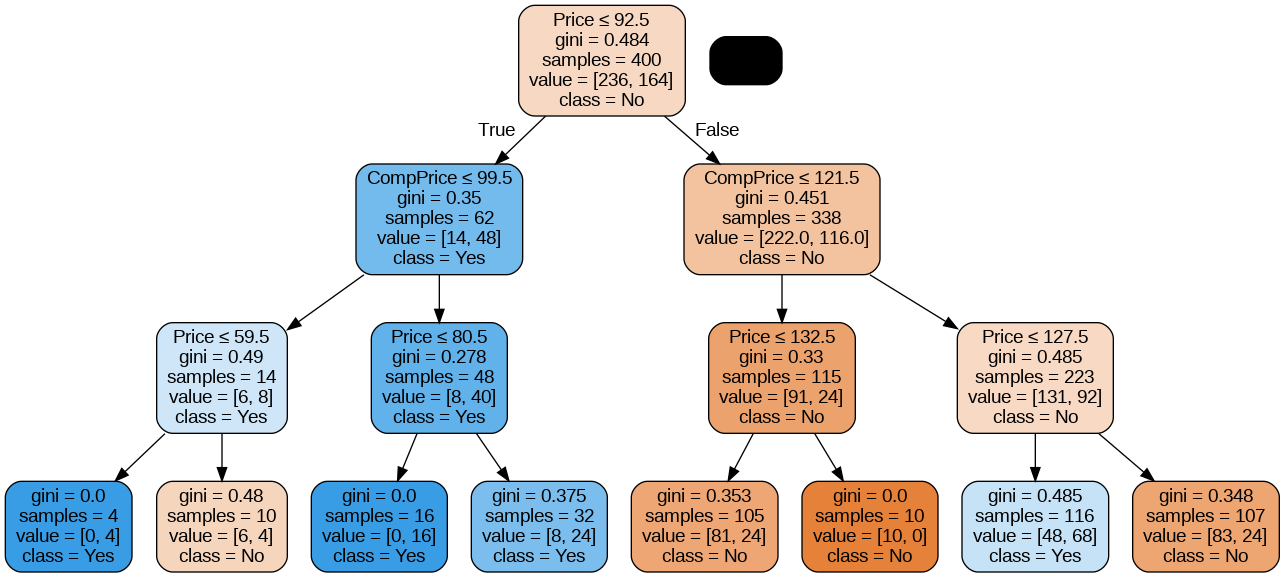

In [8]:
continuous = ['Price','CompPrice']
preprocess = Pipeline([('Select Continuous',DataFrameSelector(continuous))])

X = preprocess.fit_transform(data.drop(columns=['High'])) #Run Pipeline
y = data['High']

#Fit Model
clf = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1) #If depth is not set, it constructs a very deep tree
clf = clf.fit(X, y)

conf = confusion_matrix(data['High'],clf.predict(X))
print('Training Accuracy = ',(conf[1,1]+conf[0,0])/(conf[0,0]+conf[0,1]+conf[1,0]+conf[1,1]))
print('Training Accuracy = ',clf.score(X,y)) #score(X_test,y_test) function calls predict() and calculates error

dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=continuous, #names of the features being used
                         class_names=['No','Yes'], #for categorical variables only
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)


Image(graph.create_png())

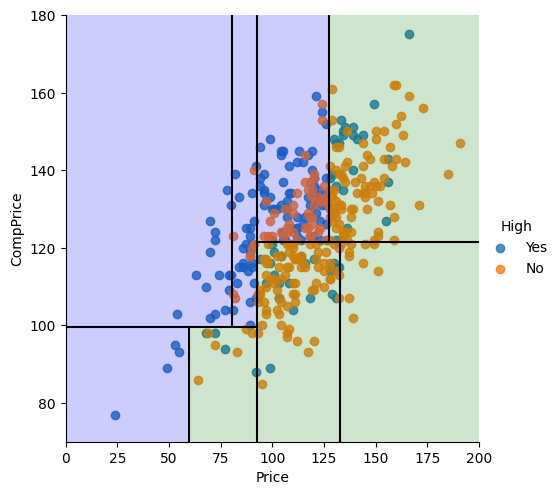

In [9]:
sns.lmplot(x='Price',y='CompPrice',fit_reg = False,hue = 'High',data = data)

#Boundries
plt.axis(xmin=0,xmax=200,ymin=70,ymax=180)
plt.axvline(x = 92.5,c = 'black')
plt.plot([0,92.5],[99.5,99.5],c = 'black')
plt.plot([59.5,59.5],[70,99.5],c = 'black')
plt.plot([80.5,80.5],[99.5,200],c = 'black')
plt.plot([92.5,200],[121.5,121.5],c = 'black')
plt.plot([132.5,132.5],[0,121.5],c = 'black')
plt.plot([127.5,127.5],[121.5,200],c = 'black')

#Fill
plt.fill([0,0,59.5,59.5],[0,99.5,99.5,0],facecolor = 'blue',alpha = 0.2)
plt.fill([59.5,59.5,92.5,92.5],[0,99.5,99.5,0],facecolor = 'green',alpha = 0.2)
plt.fill([0,0,92.5,92.5],[99.5,180,180,99.5],facecolor = 'blue',alpha = 0.2) # 2 regions
plt.fill([92.5,92.5,200,200],[0,121.5,121.5,0],facecolor = 'green',alpha = 0.2) #2 regions
plt.fill([92.5,92.5,127.5,127.5],[121.5,180,180,121.5],facecolor = 'blue',alpha = 0.2)
plt.fill([127.5,127.5,200,200],[121.5,180,180,121.5],facecolor = 'green',alpha = 0.2)
plt.show()

Looking at the tree generated for **price** and **competitor pricing**, we have limited the depth of the tree to 3 layers. You can test it with no depth limit, the resulting tree is very deep, and we will certainly be overfitting the data.

The regions of partition are shown above, the shaded region will be the predicted sales. Hence, given an unknown store, we can predict the sales by simply starting from the top of the tree and working our way down, or looking at which region we fall into.

### Tree with All Features
When we look at more than 3 features, visualizing segmented regions is impossible. However, we can still visualize a tree. This section looks at fitting all the features and we explore how to avoid overfitting through cross validation.

In [10]:
# Convert other string variables to numeric
data2 = data.copy() #Use separate dataframe to add columns
data2["ShelveLoc"], _  = pd.factorize(data2["ShelveLoc"])
data2["Urban"], _ = pd.factorize(data2["Urban"])
data2["US"], _ = pd.factorize(data2["US"])

collist = [x for x in data2.columns if x not in ('Sales', 'High')]
clf = tree.DecisionTreeClassifier()
X = data2[collist].values
y = data2["High"].values
fit1 = clf.fit(X, y)

In [11]:
data2.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,0,0,Yes
1,11.22,111,48,16,260,83,1,65,10,0,0,Yes
2,10.06,113,35,10,269,80,2,59,12,0,0,Yes
3,7.40,117,100,4,466,97,2,55,14,0,0,No
4,4.15,141,64,3,340,128,0,38,13,0,1,No


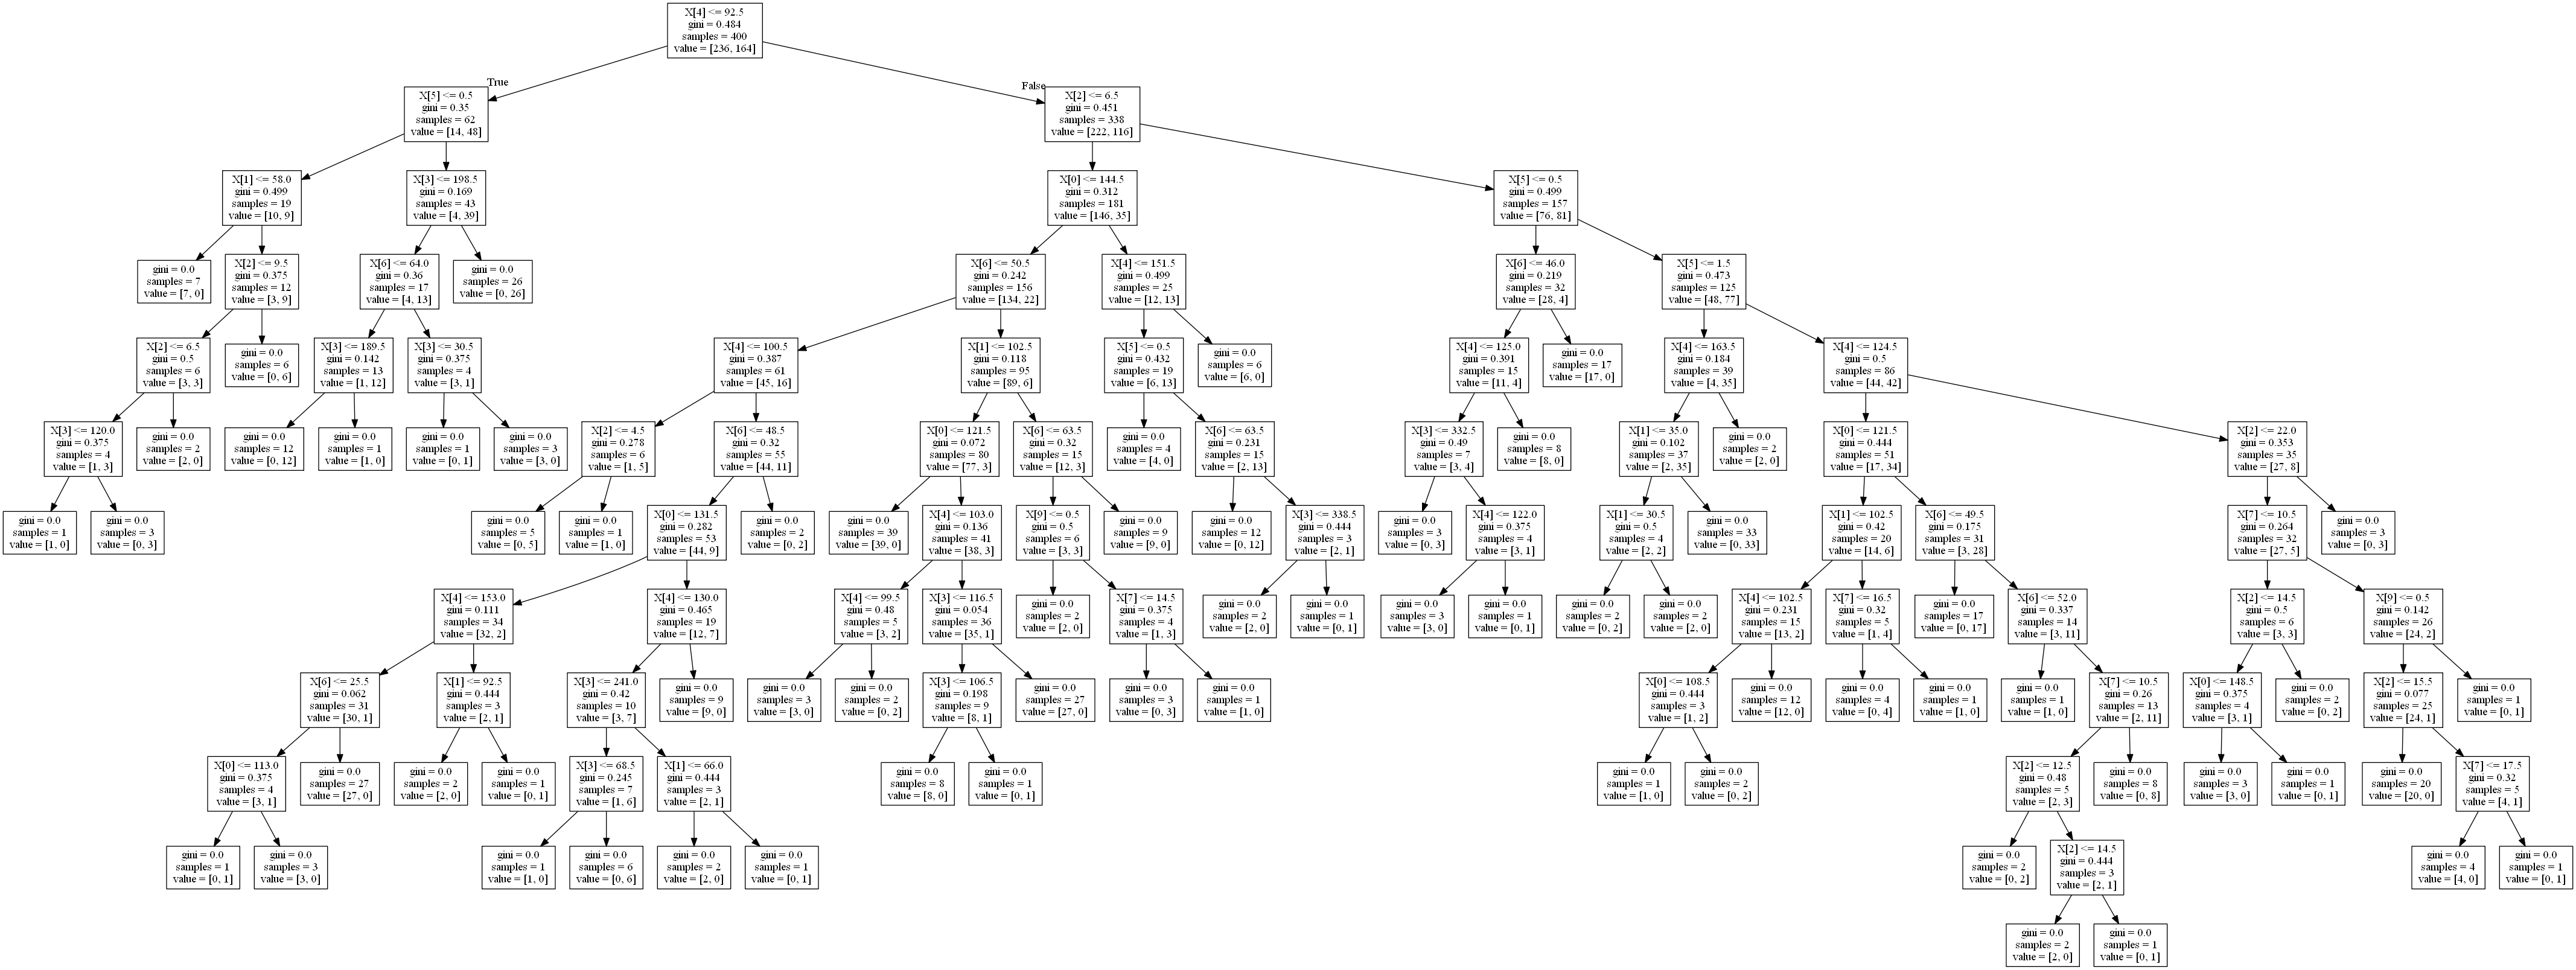

In [ ]:
#Visualize tree with all features
dot_data = tree.export_graphviz(clf, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

This tree is very deep and almost certainly overfits our data. We must run a cross validation to select which depth to use.

### Cross validation to select tree-depth

In [13]:
continuous = ['CompPrice','Income','Advertising','Population','Price','Age','Education'] #Define continuous variables
catagorical = ['ShelveLoc','Urban','US'] #Define categorical variables

preprocess = Pipeline([
    ('Feature Union',FeatureUnion([
        ('Continuous Variables',DataFrameSelector(continuous)),
        ('ShelveLoc',Pipeline([
            ('Select Feature',DataFrameSelector(catagorical[0])),
            ('One hot encoding',MyLabelBinarizer(sparse_output = False)),
            ('Subset Selection',CatagorySubset())
        ])),
        ('Urban',Pipeline([
            ('Select Feature',DataFrameSelector(catagorical[1])),
            ('One hot encoding',MyLabelBinarizer(sparse_output = False))
        ])),
        ('US',Pipeline([
            ('Select Feature',DataFrameSelector(catagorical[2])),
            ('One hot encoding',MyLabelBinarizer(sparse_output = False))
        ]))
    ]))
])

In [14]:
train,test = train_test_split(data,test_size = 0.2,random_state = 1) #Split data
X_train = preprocess.fit_transform(train.drop(columns=['High'])) #Run pipeline to preprocess the data
y_train= train['High']

In [15]:
#Fit Model
clf = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
clf = clf.fit(X_train, y_train)

X_test = preprocess.transform(test.drop(columns=['High'])) #Use transform() NOT fit_transform()!
y_test = test['High']
conf = confusion_matrix(clf.predict(X_test),test['High'])
print('Confusion Matrix: \n',conf)
print('Accuracy = ',clf.score(X_test, y_test))

Confusion Matrix: 
 [[36 14]
 [12 18]]
Accuracy =  0.675


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


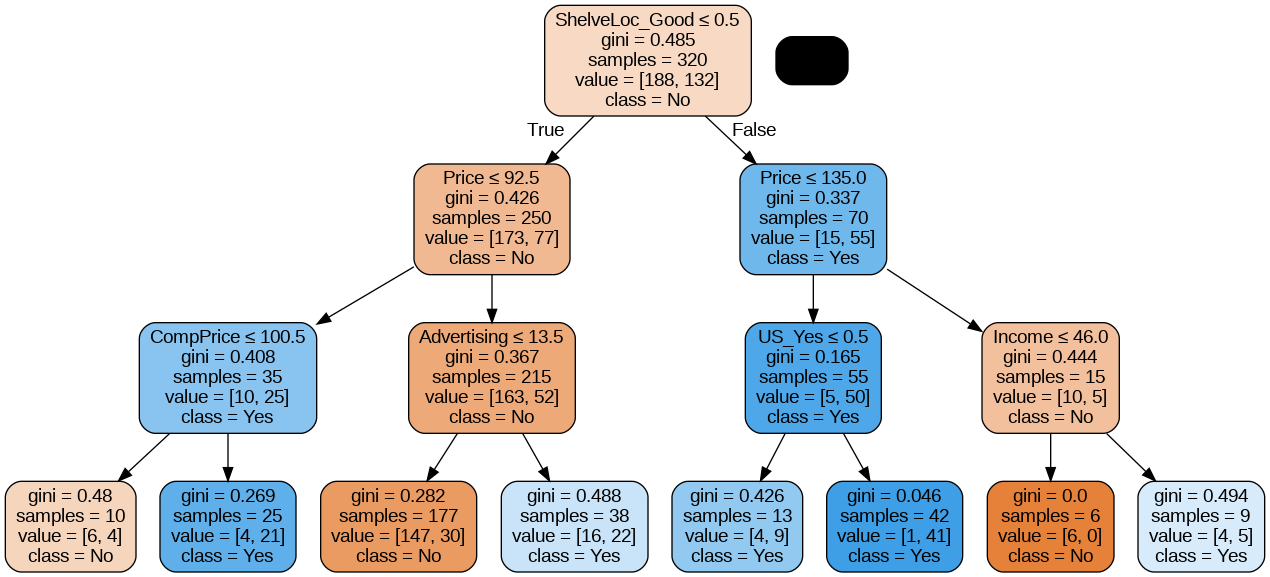

In [16]:
features = ['CompPrice','Income','Advertising','Population','Price','Age','Education','ShelveLoc_Good','ShelveLoc_Medium','Urban_Yes','US_Yes']

dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=features,
                         class_names=['No','Yes'],
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

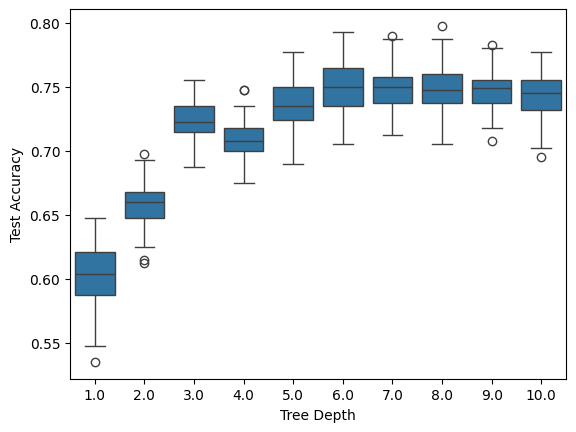

In [17]:
#We perform a 100 try 10-fold cross validation
score = np.array([])# Array to store Accuracy
depth = np.array([]) # Array to store tree depth
clf = tree.DecisionTreeClassifier() #Define model ot be used
for trial in range(100):
    cv_method = KFold(n_splits=10,shuffle=True) #Define CV method
    for tree_depth in range(1,11,1):
        clf.set_params(max_depth = tree_depth)
        depth = np.append(depth,tree_depth)
        error = np.mean(cross_val_score(clf,X,y,cv = cv_method,scoring = 'accuracy')) #Run CV
        score = np.append(score,error) #KFold tests on portion of data

sns.boxplot(x = depth,y = score);
plt.xlabel('Tree Depth');
plt.ylabel('Test Accuracy');

Looking at the plot above, over 100 fits, we can conclude that a tree depth of 6 is a good choice. We see that, based on the median and IRQ, deeper trees lead to decreased accuracy; this is due to overfitting the training data.

In [ ]:
score = np.array([])# Array to store Misclassification Error
depth = np.array([]) # Array to store tree depth
for trial in range(100):
    train,test = train_test_split(data,test_size = 0.2) #Split Data
    X_train = preprocess.fit_transform(train.drop(columns=['High'])) #Drop the output variable column
    X_test = preprocess.transform(test.drop(columns=['High'])) #Use transform() NOT fit_transform()!
    y = train['High']
    for tree_depth in range(1,11,1):
        clf = tree.DecisionTreeClassifier(max_depth = tree_depth+2)
        depth = np.append(depth,tree_depth+2)
        clf = clf.fit(X_train,y)
        score = np.append(score,clf.score(X_test,test['High']))

sns.boxplot(x = depth,y = score)
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.show()

The plot above is training all of the training data and testing it against the 20% testing data. Again, we see that a tree depth of 6 does fairly well, although there is still some variability as the test accuracy ranges from 62% to 85%. Note, we **do not** tune our parameters by looking at this plot, this is only for illustrative purposes. Instead, we use a method called hyper-parameter optimization.

### Bootstrap Aggregating (Bagging)
A common issue with trees is the incredible variance in results we experience depending on the training and testing split. You can experiment with this by changing the *random_state* in the *train_test_split()* function above. One way to circumvent this problem is through bootstrap aggregating (Bagging).

Just like we did with bootstrap, we resample the dataset with replacement. Each of these iterations constitute one bootstrap sample. We construct **B** bootstrap samples and fit B trees to these samples. Finally, we average all the predictions. In a regression context it is easy to average the predictions, with classification we choose to take the majority vote across the B predictions.

If we have **N** observations in our training set, and we sample with replacement, certain observations will not make it into the bootstrap training set. This is an important consequence of the bootstrap process and it allows us to calculate testing error without touching the testing dataset or without performing cross validation.

Samples not included in the training bootstrap set are called **out of bag** samples. Therefore, the error we calculate is called **out of bag error**. Everytime we fit a tree to the  bootstrap dataset we can calculate the out of bag error.


## Random Forest
Random forest works exactly liked bagged trees with one additional change, only **m** predictors are chosen as split candidates for each tree. Therefore, in each of the **B** trees constructed we randomly choose **m** predictors. Only these predictors may be used to perform the split, all other columns are invisible. For each new tree a fresh sample of **m** predictors are chosen and a deep tree is constructed.

This process decorrelates each of the trees. When aggregating the trees (averaging or majority vote) the results are less variable and more reliable.

A special case is when we set $m=p$ where $p$ = total number of predictors, the result is a bootstrap tree, when $m<p$ we get random forest. The documentation shows that using random forest, if m is not specified, the default is $m=p$.

To perform a Random Forest Classification we use sklearn.ensemble.RandomForestClassifier(). We can also use RandomForestRegressor() to perform a regressor.

### Hyper-parameter optimization

Hyper-parameters are the arguments we pass into the constructor of the estimator class. The constructors can be *LinearRegression(),LogisticRegression()* and now we will be using *RandomForestClassifier()* for predicting categorical variables. We can also predict continuous variables with *RandomForestRegressor()*.

Looking at the documentation for *RandomForestClassifier()* we see that various parameters which dictate the behavior of the learning algorithm. We can tune these parameters to achieve the optimal learning model for each project.

The parameters we will be focusing to tune are **n_estimators** which is the number of trees (referred to as **B** above), and **max_features** which is the number of features we consider as splitting candidates for each tree (referred to as **m** above).

There are various methods to perform hyper-parameter tuning, these include,

1. Exhaustive grid search: We provide a set of n_estimators and max_features and it tries every permutation. Compared against some error function.
2. Randomized parameter search: When we have many hyper parameters to tune, this algorithm chooses permutations at random.
3. Cross validation
4. Out of bag estimates

### Further Reading

* Hyper-parameter Optimization: http://scikit-learn.org/stable/modules/grid_search.html
* RandomForestClassifier: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


Here, we will run our own vanilla version of tuning by looking at the accuracy score. Note that this process is very computationally expensive. To tune parameters, we would perform a GridSearch or RandomizedSearch, which loop through parameters efficiently to perform hyper-parameter optimization.

In [19]:
train,test = train_test_split(data,test_size = 0.2,random_state = 1) #Split Data
X_train = preprocess.fit_transform(train.drop(columns=['High'])) #Run Pipeline
y_train= train['High']
X_test = preprocess.transform(test.drop(columns=['High'])) #Use transform() NOT fit_transform()!
y_test = test['High']

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


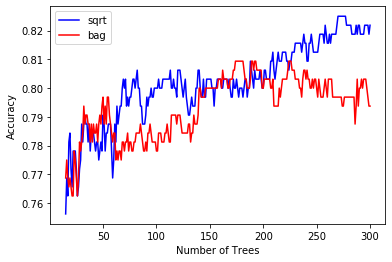

In [ ]:
error_rate_sqrt = np.array([])
num_trees_sqrt = np.array([])

error_rate_bag = np.array([])
num_trees_bag = np.array([])

min_trees = 15
max_trees = 300

clf_sqrt = RandomForestClassifier(warm_start=False,
                             oob_score=True,
                             max_features="sqrt",
                             random_state = 1)

clf_bagging = RandomForestClassifier(warm_start=False,
                             oob_score=True,
                             max_features=None,
                             random_state = 1)

for i in range(min_trees,max_trees+1):
    clf_sqrt.set_params(n_estimators=i)
    clf_sqrt.fit(X_train, y_train)
    error_rate_sqrt = np.append(error_rate_sqrt,clf_sqrt.oob_score_)
    num_trees_sqrt = np.append(num_trees_sqrt,i)

    clf_bagging.set_params(n_estimators=i)
    clf_bagging.fit(X_train, y_train)
    error_rate_bag = np.append(error_rate_bag,clf_bagging.oob_score_)
    num_trees_bag = np.append(num_trees_bag,i)

plt.plot(num_trees_sqrt,error_rate_sqrt,c='blue',label='sqrt');
plt.plot(num_trees_bag,error_rate_bag,c='red',label='bag');
plt.legend();
plt.xlabel('Number of Trees');
plt.ylabel('Accuracy');

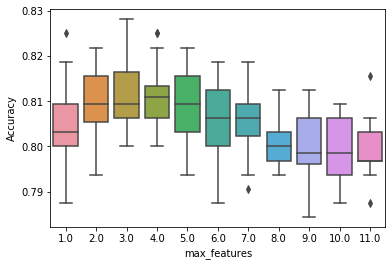

In [ ]:
error_rate = np.array([])
num_trees = np.array([])

min_features = 1
max_features = 11


for trial in range(20):
    clf = RandomForestClassifier(oob_score=True,
                             n_estimators=500,
                             random_state = trial)
    for m in range(min_features,max_features+1):
        clf.set_params(max_features=m)
        clf.fit(X_train, y_train)
        error_rate = np.append(error_rate,clf.oob_score_)
        num_trees = np.append(num_trees,m)

sns.boxplot(x = num_trees,y = error_rate)
plt.xlabel('max_features');
plt.ylabel('Accuracy');

Comparing random forest with single trees, we immediately see an improvement in accuracy. With single trees, we optimized our model to achieve a median training accuracy of $\approx$70%. However, with random forest, we  are getting an OOB accuracy of over 80%. Looking at the plots of Accuracy vs. Number of trees above, it looks like the accuracy levels out after 200 trees, to be safe I have chosen 500 trees.

Keeping this constant we optimize the number of feature to split on. This is found to be 4 features from the plot above, as shown by the median in the boxplots.

### Classifier Design

As we have seen with logistic regression it is also possible to construct a classifier with a random forest model. It is not always the best choice to choose the majority vote (>50%). This can be achieved by calling the *predict_proba()* function on the model you have fit.

In [ ]:
clf = RandomForestClassifier(oob_score=True,
                             n_estimators=500,
                             max_features = 4)

clf.fit(X_train,y_train)
probs = clf.predict_proba(X_test) #Get class probabilities
print(probs.tolist())

[[0.704, 0.296], [0.35, 0.65], [0.912, 0.088], [0.264, 0.736], [0.072, 0.928], [0.39, 0.61], [0.988, 0.012], [0.258, 0.742], [0.47, 0.53], [0.794, 0.206], [0.902, 0.098], [0.85, 0.15], [0.596, 0.404], [0.93, 0.07], [0.648, 0.352], [0.546, 0.454], [0.756, 0.244], [0.346, 0.654], [0.966, 0.034], [0.884, 0.116], [0.894, 0.106], [0.976, 0.024], [0.654, 0.346], [0.9, 0.1], [0.134, 0.866], [0.668, 0.332], [0.824, 0.176], [0.804, 0.196], [0.46, 0.54], [0.914, 0.086], [0.712, 0.288], [0.882, 0.118], [0.832, 0.168], [0.742, 0.258], [0.94, 0.06], [0.258, 0.742], [0.636, 0.364], [0.906, 0.094], [0.802, 0.198], [0.186, 0.814], [0.628, 0.372], [0.586, 0.414], [0.382, 0.618], [0.956, 0.044], [0.74, 0.26], [0.912, 0.088], [0.618, 0.382], [0.834, 0.166], [0.272, 0.728], [0.308, 0.692], [0.974, 0.026], [0.522, 0.478], [0.342, 0.658], [0.118, 0.882], [0.168, 0.832], [0.566, 0.434], [0.298, 0.702], [0.636, 0.364], [0.54, 0.46], [0.122, 0.878], [0.698, 0.302], [0.502, 0.498], [0.11, 0.89], [0.576, 0.424],

As seen above, the output is the probabilities for each class. Using this, you can threshold on various values to obtain an **AUC, misclassification, positive prediction, negative prediction curves.**

The final model we have constructed is shown below.

In [ ]:
clf = RandomForestClassifier(oob_score=True,
                             n_estimators=500,
                             max_features = 4)

clf.fit(X_train,y_train)

print('Training OOB accuracy',clf.oob_score_)
print('Testing accuracy: ',clf.score(X_test,y_test))

Training OOB accuracy 0.815625
Testing accuracy:  0.7875


## Boston Dataset

### Fitting Regression Trees

Here we fit a regression tree to the Boston data set. First, we create a
training set, and fit the tree to the training data using only three predictors.

In [ ]:
#Import data and take a look at features

from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston_df = pd.DataFrame(data = boston_dataset.data, columns = boston_dataset.feature_names)
boston_df['MEDV'] = pd.Series(boston_dataset.target)
boston_df.columns = map(str.lower, boston_df.columns) #make all the column names lowercase
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
collist = ['lstat', 'rm', 'dis'] #only uses a subset of predictors
X = boston_df[collist]
y = boston_df['medv'] #target output

#Split Data
X_train, X_test, y_train, y_test = train_test_split(
                X, y,test_size = 0.2,random_state = 1)

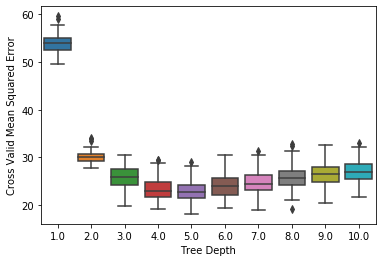

In [ ]:
#Perform a 100 try 10-fold cross validation
score = np.array([])# Array to store Misclassification Error
depth = np.array([]) # Array to store tree depth
rgr = tree.DecisionTreeRegressor() #Define model ot be used
for trial in range(100):
    cv_method = KFold(n_splits=10,shuffle=True) #Define CV method
    for tree_depth in range(1,11,1):
        rgr.set_params(max_depth = tree_depth)
        depth = np.append(depth,tree_depth)
        error = -1*np.mean(cross_val_score(rgr,X,y,cv = cv_method,scoring = 'neg_mean_squared_error')) #Run cross validation
        score = np.append(score,error)

sns.boxplot(x = depth,y = score)
plt.xlabel('Tree Depth')
plt.ylabel('Cross Valid Mean Squared Error')
plt.show()

Looking at the plot above, over 100 fits, we see that a tree depth of 4 is does fairly well based on its median being the lowest. Now let's fit to our training data and view the resulting tree

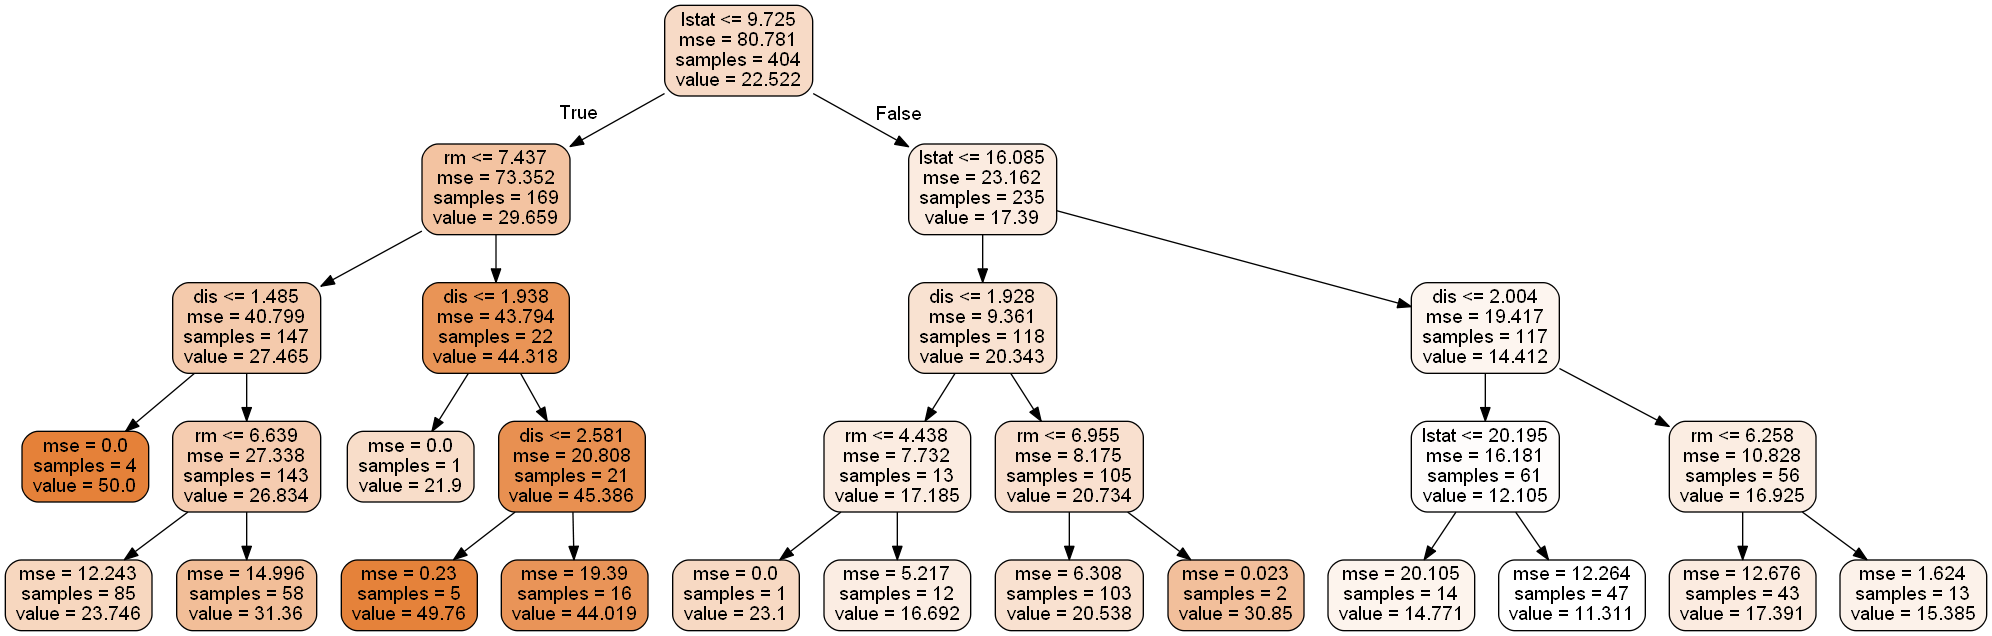

In [ ]:
rgr = tree.DecisionTreeRegressor(max_depth=4)
rgr.fit(X_train, y_train)
#Visualize Tree
dot_data = tree.export_graphviz(rgr, out_file=None,
                         feature_names=collist,
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
#Let's calculate the MSE
mean_squared_error(rgr.predict(X_test), y_test)

20.791354247024195

In [ ]:
np.sqrt(mean_squared_error(rgr.predict(X_test), y_test))

4.559753748507061

In other words, the test set MSE associated with the regression tree is
28.182. The square root of the MSE is therefore around 5.309, indicating
that this model leads to test predictions that are within around $5,309 of
the true median home value for the suburb.

## Bagging and Random Forests

In [ ]:
# Fit a bootstrap tree
br = BaggingRegressor(random_state=1)
br.fit(X_train, y_train)
print('The Bootstrap Tree MSE is', mean_squared_error(br.predict(X_test), y_test))

The Bootstrap Tree MSE is 18.653549019607844


In [ ]:
# Fit a random forest by setting the max_features paramater to 'sqrt'
rgr = RandomForestRegressor(max_features='sqrt', random_state=1)
rgr.fit(X_train, y_train)
print('The Random Forest MSE is',  mean_squared_error(rgr.predict(X_test), y_test))

The Random Forest MSE is 17.015179882352935


In this case, Random Forest results in a lower test MSE.

In [ ]:
collist2 = [x for x in boston_df.columns if x not in ('medv')]
X2 = boston_df[collist2]
y2 = boston_df['medv'] #target output

#Split Data
X_train2, X_test2, y_train2, y_test2 = train_test_split(
                X2, y2,test_size = 0.2,random_state = 1)

In [ ]:
# Fit a bootstrap tree
br = BaggingRegressor(random_state=1)
br.fit(X_train2, y_train2)
print('The Bootstrap Tree MSE is', mean_squared_error(br.predict(X_test2), y_test2))

The Bootstrap Tree MSE is 11.22653039215686


In [ ]:
# Fit a random forest by setting the max_features paramater to 'sqrt'
rgr = RandomForestRegressor(max_features='sqrt', random_state=1)
rgr.fit(X_train2, y_train2)
print('The Random Forest MSE is',  mean_squared_error(rgr.predict(X_test2), y_test2))

The Random Forest MSE is 10.690168401960808


## Boosting

Boosting builds lots of small trees. Unlike Random Forests, each tree tries to make up for the deficiencies in the current ensemble. With Boosting, the number of trees is a tuning parameter. Using the same train/test split, we plot the MSE against the number of trees.

In [ ]:
# Fit a boosted tree
reg = GradientBoostingRegressor(random_state=1)
reg.fit(X_train2, y_train2)
print('The Boosting MSE is',  mean_squared_error(reg.predict(X_test2), y_test2))

The Boosting MSE is 8.234022976843915


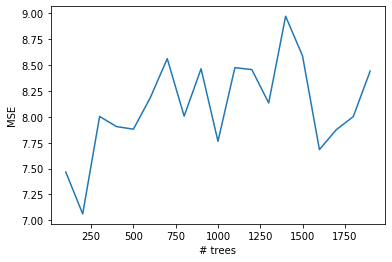

In [ ]:
num_trees = range(100, 2000, 100)
mses = []
for num_tree in num_trees:
    reg = GradientBoostingRegressor(n_estimators=num_tree)
    reg.fit(X_train2, y_train2)
    ypred = reg.predict(X_test2)
    mses.append(mean_squared_error(y_test2, ypred))
plt.plot(num_trees, mses);
plt.xlabel("# trees");
plt.ylabel("MSE");

As we can see the performance is even better than bagging or random forest, with the lowest test MSE around 250 trees.